In [1]:
# Construct network with rank k connectivity and check if dimension of dynamics
# is low rank

In [2]:
cd /Users/cl1704/PycharmProjects/clustering_in_rnns

/Users/cl1704/PycharmProjects/clustering_in_rnns


In [3]:
from Experiment_1.TwoAFCTask import generate_trials
import networkx as nx
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
from Experiment_1.net import *
import os
import statsmodels.api as sm
import scipy.optimize as opt
import math
#from psychometrics import *
from sklearn.cluster import DBSCAN
from scipy.stats import ortho_group

from sklearn.decomposition import PCA
import networkx as nx
from sklearn.cluster import KMeans
plt.rcParams["axes.grid"] = False
from sklearn.manifold import TSNE
matplotlib.rcParams['axes.linewidth'] = .5

In [4]:
import torch
import torch.nn as nn
import numpy as np
#from scipy.sparse import random
from scipy import stats
from numpy import linalg
from sklearn.decomposition import PCA
from torch.utils.data import TensorDataset, DataLoader
import random as rdm
from Connectivity import *
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

class NetRates(torch.nn.Module):
    def __init__(self, n, alpha = .2, sigma_rec=0.15,sigma_in=0.2, input_size=6, output_size=2,dale=False,activation = torch.nn.ReLU(),dropout = 5 ):
        super(NetRates, self).__init__()
        self.alpha = torch.tensor(alpha)
        self.sigma_rec = torch.tensor(sigma_rec)
        self.sigma_in = torch.tensor(sigma_in)
        self.n = n
        self.input_size = input_size
        self.output_size = output_size
        self.activation = activation
        self.dale = dale
        self.dropout = dropout
        
        # Connectivity
        self.recurrent_layer = nn.Linear(self.n, self.n, bias=True)
        self.recurrent_layer.weight.data.fill_diagonal_(0)
        self.recurrent_layer.weight.data.normal_(mean=0., std=0.025).to(device=device)

        self.recurrent_layer.bias.data.normal_(mean=0.2, std=0).to(device=device)
        self.recurrent_layer.bias.requires_grad = False

        self.input_layer = nn.Linear(self.input_size, self.n, bias=False)
        self.input_layer.weight.data.normal_(mean=.2, std=0.025).to(device=device)
        #self.input_layer.weight.data = torch.where(torch.rand_like(self.input_layer.weight.data)> 0.5, -self.input_layer.weight.data, self.input_layer.weight.data)

        self.output_layer = nn.Linear(self.n, self.output_size, bias=False)
        self.output_layer.weight.data.normal_(mean=0.2, std=0.025).to(device=device)
        #self.output_layer.weight.data = torch.where(torch.rand_like(self.output_layer.weight.data)> 0.5, -self.output_layer.weight.data, self.output_layer.weight.data)


        # init_connectivity(self, device,self.n, radius=1.5, recurrent_sparsity=1, input_sparsity=1, output_sparsity=1,
        #                   input_size=2, output_size=2)

    # Dynamics
    def forward(self, u,initial_states = None):
        t = u.shape[1]
        if initial_states is None:
            states = torch.zeros(u.shape[0], 1, self.n, device=device)
        else:
            states = initial_states
        batch_size = states.shape[0]
        input_noise = torch.sqrt(2 / self.alpha * self.sigma_in ** 2) * torch.empty(batch_size, t, self.input_size).normal_(mean=0,
                                                                                                              std=1).to(
            device=device)
      
        recurrent_noise = torch.zeros(batch_size, t, self.n).to(device=device)
        inputs = self.input_layer(u+input_noise)
        for i in range(t - 1):
            state_new = (1 - self.alpha) * states[:, i, :] + self.alpha * (
                self.activation(self.recurrent_layer(states[:, i, :]) + inputs[:, i, :]  ) + recurrent_noise[:, i, :])
            states = torch.cat((states, state_new.unsqueeze_(1)), 1)

        #dropout: randomly zero out the responses of some neurons
        # if training:
        #     dropped_units = rdm.sample(set(np.arange(states.shape[2])), self.dropout)
        #     states[:, :, dropped_units] = 0
        return states

    def loss_function(self, x, z, u, mask, lvar, lstd,dim):
        return self.mse_z(x,z,mask) + lvar * self.variance(x, dim) 



    def fit(self, u, z, mask, conditions, dim, lvar = 0,lstd = 0,epochs = 10000, lr=.01, verbose = False, weight_decay = 0):

        my_dataset = TensorDataset(u, z, mask)  # create your datset
        my_dataloader = DataLoader(my_dataset, batch_size=64)
        
        optimizer = torch.optim.Adam(self.parameters(), lr=lr, weight_decay = weight_decay)
        epoch = 0
        #mse_z=1
        while epoch < epochs:
            for batch_idx, (u_batch, z_batch, mask_batch) in enumerate(my_dataloader):
                optimizer.zero_grad()
                x_batch = self.forward(u_batch,training=True)
                loss = self.loss_function(x_batch, z_batch, u_batch,mask_batch, lvar,lstd, dim)
                loss.backward()
                optimizer.step()
                self.recurrent_layer.weight.data.fill_diagonal_(0)
                # self.recurrent_layer.weight.data = torch.relu(
                #     self.recurrent_layer.weight.data * self.dale_mask) * self.dale_mask
                # self.input_layer.weight.data = self.input_mask * torch.relu(
                #     self.input_layer.weight.data)
                # self.output_layer.weight.data = self.output_mask * torch.relu(
                #     self.output_layer.weight.data)
                
                #mse_z = self.mse_z(x, z, mask).item()
    
                epoch += 1
                if verbose:
                    if epoch % 50 == 0:
                        x = self.forward(u)
                        print('Epoch: {}/{}.............'.format(epoch, epochs), end=' ')
                        print("mse_z: {:.4f}".format(self.mse_z(x, z, mask).item()))
                    
    


        



In [5]:



class NetActivations(torch.nn.Module):
    def __init__(self, n, alpha=.2, sigma_rec=0.15, sigma_in=0.2, input_size=2, output_size=2, dale=False,
                 activation=torch.nn.ReLU()):
        super(NetActivations, self).__init__()
        self.alpha = torch.tensor(alpha)
        self.sigma_rec = torch.tensor(sigma_rec)
        self.sigma_in = torch.tensor(sigma_in)
        self.n = n
        self.input_size = input_size
        self.output_size = output_size
        self.activation = activation
        self.dale = dale

        # Connectivity
        self.recurrent_layer = nn.Linear(self.n, self.n, bias=True)
        #self.recurrent_layer.weight.data.normal_(mean=0., std=0.025).to(device=device)
        self.recurrent_layer.weight.data.fill_diagonal_(0)
        self.recurrent_layer.bias.data.normal_(mean=0, std=0).to(device=device)
        self.recurrent_layer.bias.requires_grad = False

        self.input_layer = nn.Linear(self.input_size, self.n, bias=False)
        #self.input_layer.weight.data.normal_(mean=.2, std=.01).to(device=device)

        self.output_layer = nn.Linear(self.n, self.output_size, bias=False)
        self.output_layer.weight.data.normal_(mean=0, std=0.25).to(device=device)

    # Dynamics
    def forward(self, u, initial_states=None):
        t = u.shape[1]
        if initial_states is None:
            states = torch.zeros(u.shape[0], 1, self.n, device=device)
        else:
            states = initial_states
        batch_size = states.shape[0]
        input_noise = torch.sqrt(2 / self.alpha * self.sigma_in ** 2) * torch.empty(batch_size, t,
                                                                                    self.input_size).normal_(mean=0,
                                                                                                             std=1).to(
            device=device)

        recurrent_noise = torch.zeros(batch_size, t, self.n).to(device=device)
        inputs = self.input_layer(u + input_noise)
        for i in range(t - 1):
            state_new = (1 - self.alpha) * states[:, i, :] + self.alpha * (
                    self.recurrent_layer(self.activation(states[:, i, :])) + inputs[:, i, :] + recurrent_noise[:, i, :])
            states = torch.cat((states, state_new.unsqueeze_(1)), 1)
        return states

    def loss_function(self, x, z, mask, lvar, dim):
        return self.mse_z(x, z, mask) + lvar * self.variance(x, dim)


    def fit(self, u, z, mask, conditions, dim, lvar=0, epochs=10000, lr=.01, verbose=False, weight_decay=0):
        optimizer = torch.optim.Adam(self.parameters(), lr=lr, weight_decay=weight_decay)
        epoch = 0
        while epoch < epochs:
            optimizer.zero_grad()
            x = self.forward(u)
            loss = self.loss_function(x, z, mask, lvar, dim)
            loss.backward()
            optimizer.step()
            self.recurrent_layer.weight.data.fill_diagonal_(0)

            epoch += 1
            if verbose:
                if epoch % 50 == 0:
                    print('Epoch: {}/{}.............'.format(epoch, epochs), end=' ')
                    print("mse_z: {:.4f}".format(self.mse_z(x, z, mask).item()))




In [109]:
rank = 4
u = torch.zeros(900,75,rank)
for k in range(900):
    for r in range(rank):
        u[k,:,r] = 5*torch.rand(1)*torch.sigmoid(2*torch.rand(1))


N = 50
rows = []
variance_rates = []
variance_activations = []
# u, z, mask, conditions  = generate_trials(
#                             n_trials=100)
for run in range(200):
    q = torch.tensor(ortho_group.rvs(N)[:,:rank]).float()
    a = 2*torch.rand(rank,rank)-1
    # b = 2*torch.rand(1,N)-1
    # c = 2*torch.rand(1,N)-1
    # d = 2*torch.rand(1,N)-1
    # w = a.t() @b + c.t()@d
    w= q @a@q.t()
    ## = 2*torch.rand(N,N)-1
    
    w_in = q

    
    initial_states =  2*(torch.rand(u.shape[0],1,rank)) @ w_in.t() 
    # Rates
    net = NetRates(n=N,input_size = rank,dale=False)
    net.recurrent_layer.weight.data = w.float()
    net.recurrent_layer.bias.data = torch.tensor(0).float()
    net.input_layer.weight.data = 1*w_in
    net.output_layer.weight.data = torch.zeros(2,N).float()
    x = net(u,initial_states).detach().cpu().numpy()
    pca = PCA().fit(x.reshape(-1,x.shape[2]))
    variance_rates.append(np.sum(pca.explained_variance_ratio_[rank:]))
    
    # Activations
    net = NetActivations(n=N,input_size = rank,dale=False)
    net.recurrent_layer.weight.data = w.float()
    net.recurrent_layer.bias.data = torch.tensor(0).float()
    net.input_layer.weight.data = 1*w_in
    net.output_layer.weight.data = torch.zeros(2,N).float()
    x = net(u,initial_states).detach().cpu().numpy()
    pca = PCA().fit(x.reshape(-1,x.shape[2]))
    variance_activations.append(np.sum(pca.explained_variance_ratio_[rank:]))
    # for component in range(10):
    #     rows.append({'run':run,'component':component,'pca':pca.explained_variance_ratio_[component]})
    # 

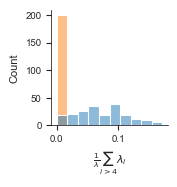

In [111]:
rows = []
for i in range(200):
    rows.append({'type':'rates',
                 'variance':variance_rates[i]})
    rows.append({'type':'activations',
                 'variance':variance_activations[i]})
df = pd.DataFrame(rows)
fig = plt.figure(figsize=(1.5,1.5))
gs = gridspec.GridSpec(1,1)
ax=fig.add_subplot(gs[0,0])
sns.histplot(data = df, x = 'variance', hue = 'type',ax=ax,legend = False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel(r"$\frac{1}{\lambda}\sum_{i>4}\lambda_i} $", fontsize=8)
ax.set_ylabel("Count", fontsize=8)
ax.xaxis.set_tick_params(labelsize=7,bottom=True)
ax.yaxis.set_tick_params(labelsize=7,left=True)
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_color('black')
fig.savefig('Figures/Fig_2afc_a.jpg',
    format='jpeg',
    dpi=450,
            bbox_inches='tight'
)


In [77]:
variance_activations

[3.5357906001279947e-11,
 3.4083897335435834e-11,
 1.6831701063778108e-11,
 1.3428264595955548e-11,
 2.478122557336891e-11,
 3.472916850738283e-11,
 3.095080519658723e-11,
 3.02936174986006e-11,
 1.2922482089882672e-11,
 1.8000937718455696e-11,
 1.3822747573788493e-11,
 3.4605105548436006e-11,
 6.692356059260717e-12,
 3.1463015055199096e-11,
 2.19696584299388e-11,
 2.060431666998511e-11,
 2.2303495314477077e-11,
 4.410188210210171e-11,
 1.1468306298991948e-11,
 1.0884151939417738e-11,
 2.7201011552366348e-11,
 9.475186846266683e-12,
 1.475897498260802e-11,
 1.6170764970552493e-11,
 2.0546757999636143e-11,
 1.428378060241817e-11,
 1.3181878979505869e-11,
 1.0617127809735993e-11,
 3.329175012326535e-11,
 1.950601526477052e-11,
 6.4373115944815145e-12,
 2.927770156674105e-11,
 4.266810351513121e-11,
 2.7285796986741423e-11,
 3.963109078548791e-11,
 4.008009664256345e-11,
 5.0100398558019586e-11,
 1.9081018012894127e-11,
 1.5578129275678213e-11,
 2.5195808853877422e-11,
 2.187254702125699e

<Axes: >

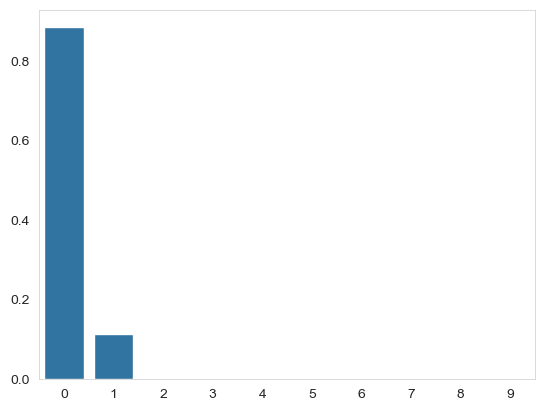

In [55]:
plt.figure()
sns.barplot(x = np.arange(10),y = pca.explained_variance_ratio_[:10])

<Axes: >

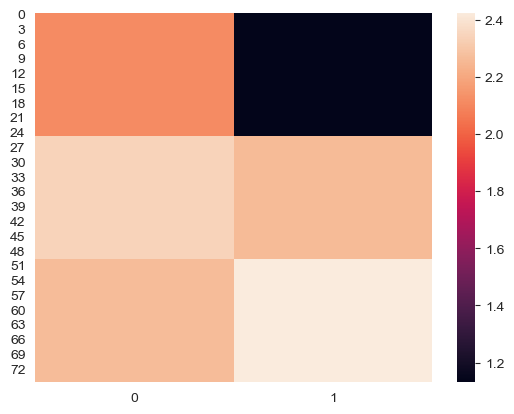

In [227]:
plt.figure()
sns.heatmap(u[2,:,:])